<a href="https://colab.research.google.com/github/psedocode01/Final-Team10/blob/main/10%ED%8C%80_%EB%82%A8%EC%98%88%EC%A3%BC_%EA%B0%80%EC%84%A41_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 가설 1 검정: 멀티 장르(장르+장르 복합)는 개별 장르보다 평점 평균이 높을 것이다.

In [ ]:
#폰트 추가

%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 1. 데이터 불러오기
movies = pd.read_csv("movies.csv")      # 칼럼: movieId, title, genres
ratings = pd.read_csv("ratings.csv")    # 칼럼: userId, movieId, rating, timestamp

# 2. 2020년 이후 데이터만 필터링
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings_post2020 = ratings[ratings['timestamp'].dt.year >= 2020]

# 3. 영화별 평균 평점 계산
movie_mean = ratings_post2020.groupby('movieId')['rating'].mean().reset_index().rename(columns={'rating':'mean_rating'})

# 4. 영화 메타데이터와 결합
movies = movies.merge(movie_mean, on='movieId', how='inner')

# 5. 장르 분리 및 원핫 인코딩
movies['genre_list'] = movies['genres'].fillna('').apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    columns=mlb.classes_,
    index=movies.index
)

movies = pd.concat([movies, genre_dummies], axis=1)

print(movies.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  mean_rating  \
0  Adventure|Animation|Children|Comedy|Fantasy     3.935294   
1                   Adventure|Children|Fantasy     3.567663   
2                               Comedy|Romance     3.105769   
3                         Comedy|Drama|Romance     3.300000   
4                                       Comedy     2.822222   

                                          genre_list  (no genres listed)  \
0  [Adventure, Animation, Children, Comedy, Fantasy]                   0   
1                     [Adventure, Children, Fantasy]                   0   
2                                  [Comedy, Romance]                   0   
3               

In [ ]:
from scipy.stats import pointbiserialr

# 로맨스+코미디 조합 여부 변수 생성
movies['RomCom'] = ((movies['Romance']==1) & (movies['Comedy']==1)).astype(int)

# Point-biserial 상관 분석
corr, pval = pointbiserialr(movies['RomCom'], movies['mean_rating'])
print("상관계수:", corr, "p-value:", pval)

상관계수: 0.02299234621237936 p-value: 2.707859574425834e-06


In [ ]:
import statsmodels.formula.api as smf

# OLS 회귀 (Romance, Comedy, Romance×Comedy)
model = smf.ols('mean_rating ~ Romance + Comedy + Romance:Comedy', data=movies).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     57.81
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           2.77e-37
Time:                        09:25:44   Log-Likelihood:                -54743.
No. Observations:               41632   AIC:                         1.095e+05
Df Residuals:                   41628   BIC:                         1.095e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0393      0.006    547.

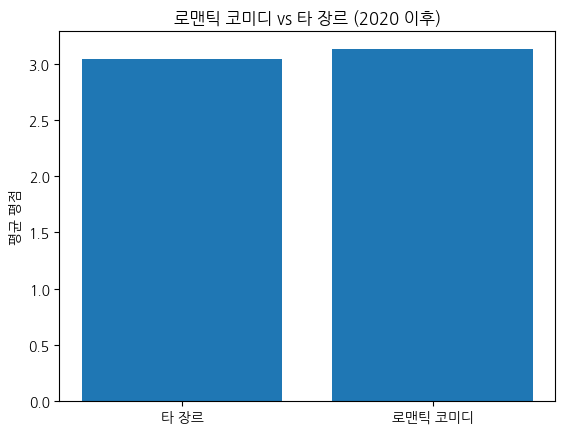

In [ ]:
import matplotlib.pyplot as plt

# 로맨틱 코미디 여부 그룹화
group_mean = movies.groupby('RomCom')['mean_rating'].mean()

plt.bar(['타 장르','로맨틱 코미디'], group_mean)
plt.ylabel("평균 평점")
plt.title("로맨틱 코미디 vs 타 장르 (2020 이후)")
plt.show()

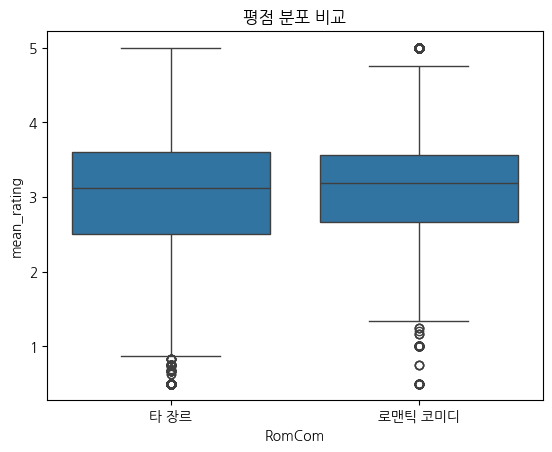

In [ ]:
import seaborn as sns

sns.boxplot(x='RomCom', y='mean_rating', data=movies)
plt.xticks([0,1], ['타 장르','로맨틱 코미디'])
plt.title("평점 분포 비교")
plt.show()

로맨스와 코미디 이외 추가적으로 다른 장르간의 조합도 함께 파악하기로 함.

In [ ]:
import pandas as pd

# movies_ratings_post2020.csv 또는 현재 데이터프레임에 'genres' 컬럼이 있다고 가정
# df = pd.read_csv("movies_ratings_post2020.csv")

# 1. 결측치 제거 후 split
all_genres = movies['genres'].dropna().apply(lambda x: x.split('|'))

# 2. 리스트 평탄화
flat_genres = [g for sublist in all_genres for g in sublist]

# 3. 빈도수 세기
genre_counts = pd.Series(flat_genres).value_counts()

print(genre_counts)

# 4. DataFrame으로 변환 (정렬 포함)
genre_df = genre_counts.reset_index()
genre_df.columns = ['genre','count']
display(genre_df)

Drama                 17313
Comedy                12400
Thriller               6697
Action                 5660
Romance                5309
Horror                 4683
Crime                  3899
Documentary            3623
Adventure              3186
Animation              2914
Sci-Fi                 2885
Children               2361
Fantasy                2322
Mystery                2204
(no genres listed)     1665
War                    1284
Western                 691
Musical                 686
Film-Noir               258
IMAX                    174
Name: count, dtype: int64


,genre,count
0,Drama,17313
1,Comedy,12400
2,Thriller,6697
3,Action,5660
4,Romance,5309
5,Horror,4683
6,Crime,3899
7,Documentary,3623
8,Adventure,3186
9,Animation,2914


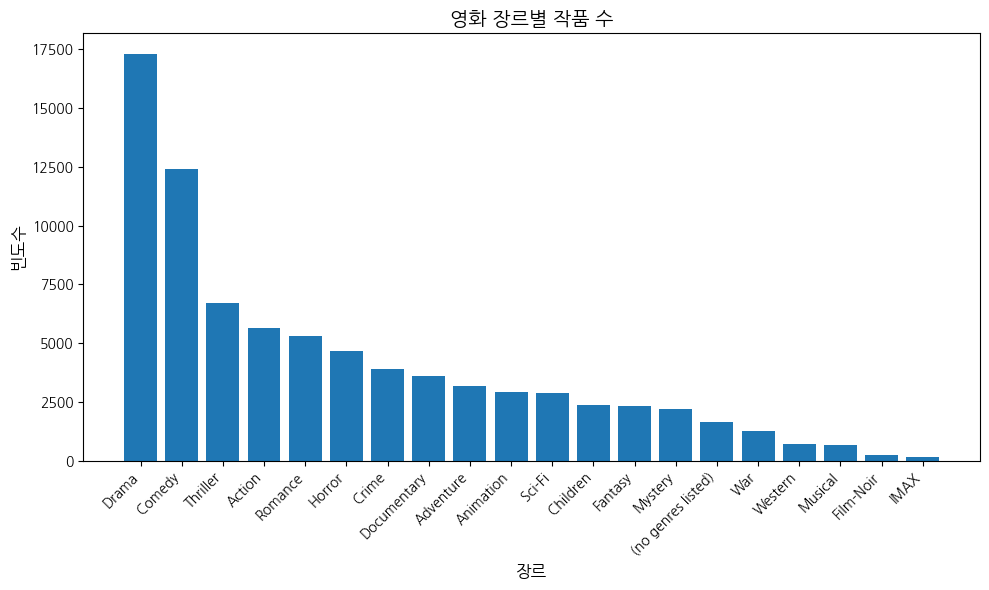

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(genre_df['genre'], genre_df['count'])
plt.xticks(rotation=45, ha='right')
plt.title("영화 장르별 작품 수", fontsize=14)
plt.xlabel("장르", fontsize=12)
plt.ylabel("빈도수", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 대표 장르
genres = ['Drama','Action','Comedy','Thriller','Adventure','Horror']

# 1) 단일 장르 평균 평점/개수 집계
rows = []
for g in genres:
    # 해당 장르가 포함된 영화
    sel = movies[movies[g] == 1]
    if len(sel) > 0:
        rows.append([g, sel['mean_rating'].mean(), len(sel)])

single_df = pd.DataFrame(rows, columns=['genre','mean_rating','n_movies'])
# 평균 평점 기준 내림차순 정렬
single_df = single_df.sort_values('mean_rating', ascending=False).reset_index(drop=True)
display(single_df)


,genre,mean_rating,n_movies
0,Drama,3.165336,17313
1,Comedy,3.027995,12400
2,Adventure,2.985562,3186
3,Action,2.906136,5660
4,Thriller,2.895794,6697
5,Horror,2.620503,4683


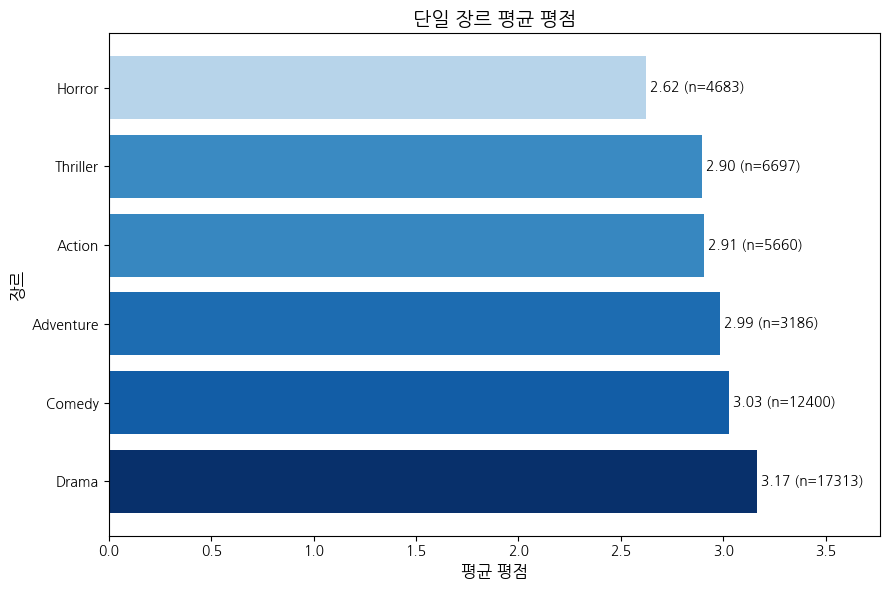

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Blues 컬러맵에서 중간~진한 부분만 사용 (0.3~1.0 구간)
cmap = plt.cm.Blues
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "truncated_blues", cmap(np.linspace(0.3, 1.0, 256))
)

norm = plt.Normalize(single_df['mean_rating'].min(), single_df['mean_rating'].max())
colors = new_cmap(norm(single_df['mean_rating']))

plt.figure(figsize=(9,6))
plt.xlim(0, single_df['mean_rating'].max() + 0.6)

bars = plt.barh(single_df['genre'], single_df['mean_rating'], color=colors)

plt.title('단일 장르 평균 평점', fontsize=14)
plt.xlabel('평균 평점', fontsize=12)
plt.ylabel('장르', fontsize=12)

for i, (v, n) in enumerate(zip(single_df['mean_rating'], single_df['n_movies'])):
    plt.text(v+0.02, i, f"{v:.2f} (n={n})", va='center')

plt.tight_layout()
plt.show()



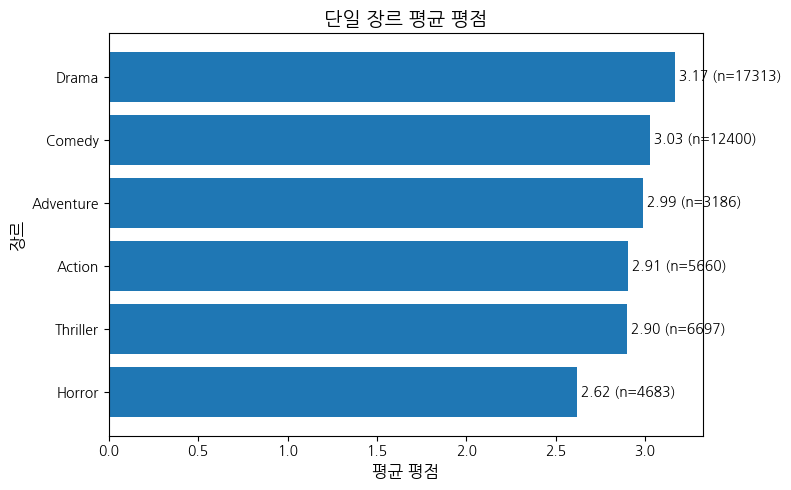

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(single_df['genre'], single_df['mean_rating'])
plt.title('단일 장르 평균 평점', fontsize=14)
plt.xlabel('평균 평점', fontsize=12)
plt.ylabel('장르', fontsize=12)

for i, (v, n) in enumerate(zip(single_df['mean_rating'], single_df['n_movies'])):
    plt.text(v, i, f" {v:.2f} (n={n})", va='center')

plt.tight_layout()
plt.gca().invert_yaxis()  # 상위가 위로 오도록
plt.show()


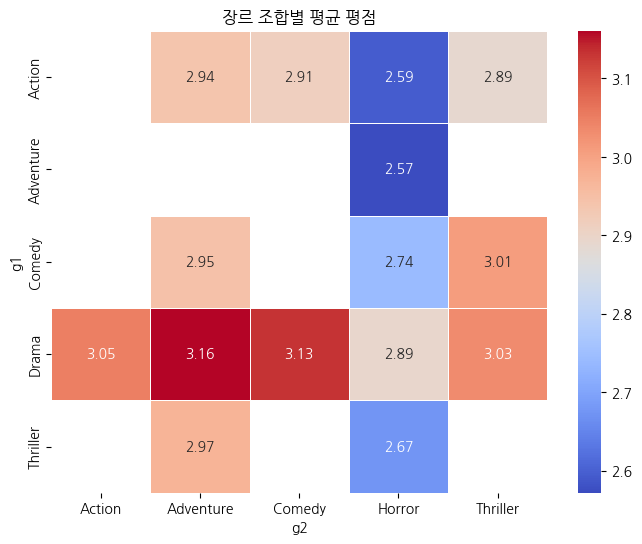

In [ ]:
#장르 조합별 평균 평점

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 분석할 대표 장르(상위 6개)
genres = ['Drama','Action','Comedy','Thriller','Adventure', 'Horror']

# 결과 저장 리스트
comb_res = []

# 2개씩 조합
for g1, g2 in itertools.combinations(genres, 2):
    sel = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(sel) > 0:
        comb_res.append([g1, g2, sel['mean_rating'].mean(), len(sel)])

# DataFrame
comb_df = pd.DataFrame(comb_res, columns=['g1','g2','mean_rating','n_movies'])

# pivot
pivot = comb_df.pivot(index='g1', columns='g2', values='mean_rating')

# 시각화
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("장르 조합별 평균 평점")
plt.show()

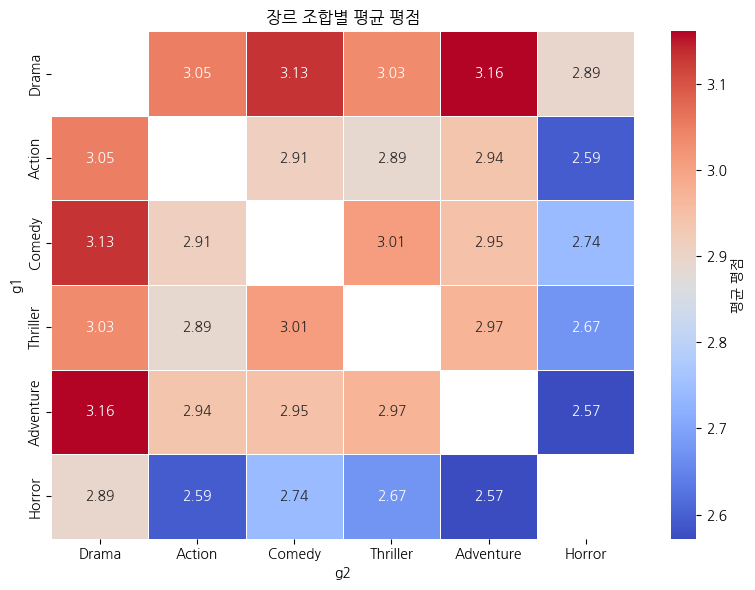

In [ ]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

genres = ['Drama','Action','Comedy','Thriller','Adventure','Horror']

# 1) 조합 평균 계산 (당신의 로직과 동일)
comb_res = []
for g1, g2 in itertools.combinations(genres, 2):
    sel = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(sel) > 0:
        comb_res.append([g1, g2, sel['mean_rating'].mean(), len(sel)])

comb_df = pd.DataFrame(comb_res, columns=['g1','g2','mean_rating','n_movies'])

# 2) 6×6 대칭 매트릭스 만들기
mat = pd.DataFrame(index=genres, columns=genres, dtype=float)

for _, row in comb_df.iterrows():
    g1, g2, m = row['g1'], row['g2'], row['mean_rating']
    mat.loc[g1, g2] = m
    mat.loc[g2, g1] = m  # 미러링

# 대각선은 표시 안 하도록 NaN
np.fill_diagonal(mat.values, np.nan)

# 3) 히트맵 (대각 마스크)
mask = np.eye(len(genres), dtype=bool)

plt.figure(figsize=(8,6))
sns.heatmap(mat, annot=True, cmap="coolwarm", fmt=".2f",
            linewidths=.5, linecolor='white', mask=mask,
            cbar_kws={"label": "평균 평점"})
plt.title("장르 조합별 평균 평점")
plt.xlabel("g2")
plt.ylabel("g1")
plt.tight_layout()
plt.show()


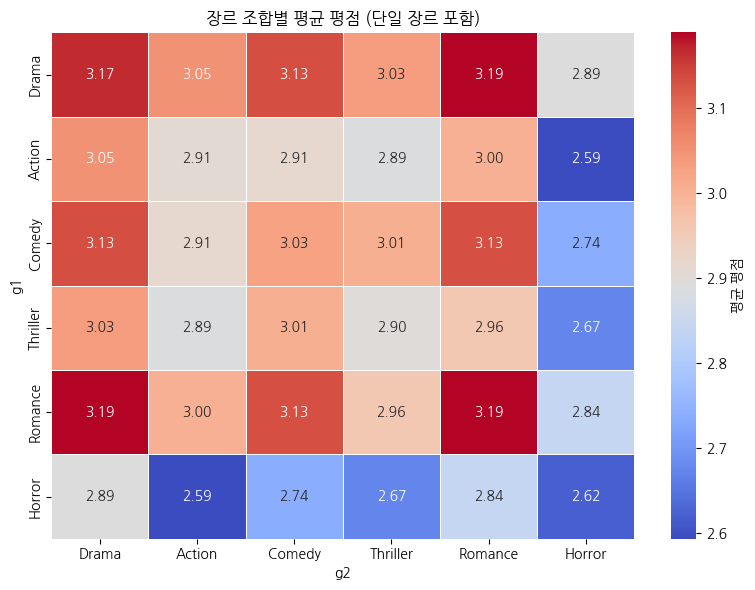

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# genres: 분석할 장르 리스트
genres = ['Drama','Action','Comedy','Thriller','Romance','Horror']

# === 1) 조합별 평균 ===
comb_res = []
for g1, g2 in itertools.combinations(genres, 2):
    sel = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(sel) > 0:
        comb_res.append([g1, g2, sel['mean_rating'].mean(), len(sel)])

comb_df = pd.DataFrame(comb_res, columns=['g1','g2','mean_rating','n_movies'])

# === 2) 6x6 매트릭스 만들기 ===
mat = pd.DataFrame(index=genres, columns=genres, dtype=float)

for _, row in comb_df.iterrows():
    g1, g2, m = row['g1'], row['g2'], row['mean_rating']
    mat.loc[g1, g2] = m
    mat.loc[g2, g1] = m

# === 3) 단일 장르 평균 평점 채우기 ===
single_res = []
for g in genres:
    sel = movies[movies[g]==1]
    if len(sel) > 0:
        single_res.append([g, sel['mean_rating'].mean()])
single_df = pd.DataFrame(single_res, columns=['genre','mean_rating'])

for g, v in zip(single_df['genre'], single_df['mean_rating']):
    mat.loc[g, g] = v   # 대각선에 단일 장르 평균 채우기

# === 4) 히트맵 ===
plt.figure(figsize=(8,6))
sns.heatmap(mat, annot=True, cmap="coolwarm", fmt=".2f",
            linewidths=.5, linecolor='white',
            cbar_kws={"label": "평균 평점"})
plt.title("장르 조합별 평균 평점 (단일 장르 포함)")
plt.xlabel("g2")
plt.ylabel("g1")
plt.tight_layout()
plt.show()


In [ ]:
# 장르별 조합 평점 검정

import itertools, numpy as np, pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import t as t_dist

# 분석할 장르들
genres = ['Drama','Action','Comedy','Thriller','Adventure','Sci-Fi']  # movies에 0/1 더미가 있어야 함

def q(col):  # patsy 인용
    return f'Q("{col}")'

rows = []
for g1, g2 in itertools.combinations(genres, 2):
    term_g1, term_g2 = q(g1), q(g2)
    inter = f'{term_g1}:{term_g2}'
    formula = f'mean_rating ~ {term_g1} + {term_g2} + {inter}'
    m = smf.ols(formula, data=movies).fit(cov_type='HC3')

    # 표본 크기(안정성 확인용)
    n11 = ((movies[g1]==1)&(movies[g2]==1)).sum()
    n10 = ((movies[g1]==1)&(movies[g2]==0)).sum()
    n01 = ((movies[g1]==0)&(movies[g2]==1)).sum()
    n00 = ((movies[g1]==0)&(movies[g2]==0)).sum()

    # ---- 상호작용(양쪽검정)
    L_int = np.array([1 if name==inter else 0 for name in m.params.index])
    t_int = m.t_test(L_int)
    beta_int = t_int.effect.item()
    p_int_2s = t_int.pvalue.item()

    # ---- 한쪽검정: μ11>μ10  (β2 + β12 > 0)
    L_gt10 = np.array([ (1 if name==term_g2 else 0) + (1 if name==inter else 0)
                        for name in m.params.index ])
    t_gt10 = m.t_test(L_gt10)
    tval1 = t_gt10.tvalue.item()
    p_gt10 = 1 - t_dist.cdf(tval1, df=m.df_resid)   # H1: >
    est_gt10 = t_gt10.effect.item()

    # ---- 한쪽검정: μ11>μ01  (β1 + β12 > 0)
    L_gt01 = np.array([ (1 if name==term_g1 else 0) + (1 if name==inter else 0)
                        for name in m.params.index ])
    t_gt01 = m.t_test(L_gt01)
    tval2 = t_gt01.tvalue.item()
    p_gt01 = 1 - t_dist.cdf(tval2, df=m.df_resid)
    est_gt01 = t_gt01.effect.item()

    rows.append({
        'g1':g1,'g2':g2,'n11':n11,'n10':n10,'n01':n01,'n00':n00,
        'beta_inter':beta_int,'p_inter_2s':p_int_2s,
        'diff_11_minus_10':est_gt10,'p_11_gt_10_1s':p_gt10,
        'diff_11_minus_01':est_gt01,'p_11_gt_01_1s':p_gt01
    })

out = pd.DataFrame(rows)

# 다중검정 보정(FDR, 쿼리군 별로)
out['p_inter_fdr'] = multipletests(out['p_inter_2s'], method='fdr_bh')[1]
out['p_11_gt_10_fdr'] = multipletests(out['p_11_gt_10_1s'], method='fdr_bh')[1]
out['p_11_gt_01_fdr'] = multipletests(out['p_11_gt_01_1s'], method='fdr_bh')[1]

# 최종 판정: 조합이 두 단일보다 모두 높다(α=0.05, FDR 보정 후)
alpha = 0.05
out['combo_higher_than_both'] = (out['p_11_gt_10_fdr']<alpha) & (out['p_11_gt_01_fdr']<alpha)

# (선택) 최소 표본 제한
min_n = 30
out.loc[(out[['n11','n10','n01']].min(axis=1)<min_n), 'combo_higher_than_both'] = False

out.sort_values(['combo_higher_than_both','p_11_gt_10_fdr','p_11_gt_01_fdr','p_inter_fdr'],
                ascending=[False,True,True,True], inplace=True)
out.head(10)


In [ ]:
from statsmodels.stats.multitest import multipletests

df = out.copy()
if 'pair' not in df.columns:
    df['pair'] = df['g1'].astype(str) + '+' + df['g2'].astype(str)

# FDR p값 자동 생성
if 'p_inter_fdr' not in df.columns:
    df['p_inter_fdr'] = multipletests(df['p_inter_2s'], method='fdr_bh')[1]
if 'p_11_gt_10_fdr' not in df.columns:
    df['p_11_gt_10_fdr'] = multipletests(df['p_11_gt_10_1s'], method='fdr_bh')[1]
if 'p_11_gt_01_fdr' not in df.columns:
    df['p_11_gt_01_fdr'] = multipletests(df['p_11_gt_01_1s'], method='fdr_bh')[1]

alpha = 0.05
df['combo_higher_than_both'] = (df['p_11_gt_10_fdr']<alpha) & (df['p_11_gt_01_fdr']<alpha)

print("유의한 교호항 개수(FDR<α):", (df['p_inter_fdr']<alpha).sum(), "/", len(df))
print("두 단일보다 모두 높은 조합 수:", df['combo_higher_than_both'].sum())
display(df.head(5))


In [ ]:
# 장르 대비 장르 조합별 차이 시각화

import numpy as np
import matplotlib.pyplot as plt

# --- (그림 1) 교호항 효과 막대 ---
d1 = df.sort_values('beta_inter', ascending=True)
plt.figure(figsize=(10,6))
plt.barh(d1['pair'], d1['beta_inter'])
plt.axvline(0, lw=1)
plt.xlabel("Interaction Effect (β_inter)")
plt.ylabel("Genre Pair")
plt.title("장르 조합별 교호항 효과")
plt.gca().invert_yaxis()

# ★ 표시
for y, ok in enumerate(d1['combo_higher_than_both']):
    if ok:
        xval = d1['beta_inter'].iloc[y]
        plt.text(xval, y, "  ★", va="center", ha="left")

plt.tight_layout()
plt.show()

# --- (그림 2) μ11−μ10 로리팝 ---
d2 = df.sort_values("diff_11_minus_10")
x = np.arange(len(d2))
plt.figure(figsize=(10,6))
plt.hlines(y=x, xmin=0, xmax=d2["diff_11_minus_10"], lw=2)
plt.plot(d2["diff_11_minus_10"], x, "o")
plt.axvline(0, lw=1)
plt.yticks(x, d2["pair"])
plt.gca().invert_yaxis()
plt.xlabel("조합 − g1만 (μ11 − μ10)")
plt.title("g1 단독 대비 차이")
plt.tight_layout()
plt.show()

# --- (그림 3) μ11−μ01 로리팝 ---
d3 = df.sort_values("diff_11_minus_01")
x = np.arange(len(d3))
plt.figure(figsize=(10,6))
plt.hlines(y=x, xmin=0, xmax=d3["diff_11_minus_01"], lw=2)
plt.plot(d3["diff_11_minus_01"], x, "o")
plt.axvline(0, lw=1)
plt.yticks(x, d3["pair"])
plt.gca().invert_yaxis()
plt.xlabel("조합 − g2만 (μ11 − μ01)")
plt.title("g2 단독 대비 차이")
plt.tight_layout()
plt.show()


장르를 더미 변수로 두고, 조합을 보고 싶으면 교호항 추가


* 양수 & 유의 → 조합이 단순 합 이상으로 시너지 효과 있음

* 음수 & 유의 → 조합이 오히려 평점을 깎아먹음 (상쇄 효과)

* 비유의 → 조합은 특별한 효과 없음, 그냥 개별 장르 합으로 설명됨

In [ ]:
# 장르별 조합 회귀분석(OLS)
movies = movies.rename(columns={'Sci-Fi':'SciFi'})
genres = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']

formula = 'mean_rating ~ ' + ' + '.join(genres)


# 모든 2개 조합 교호항 추가
for i in range(len(genres)):
    for j in range(i+1, len(genres)):
        formula += f' + {genres[i]}:{genres[j]}'

model = smf.ols(formula, data=movies).fit(cov_type="HC3")
print(model.summary())


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests


In [ ]:
# 분석할 장르 목록(필요에 맞게 수정)
genres = ['Drama','Action','Comedy','Thriller','Adventure','Horror']

# (1) 단일 장르 평균 (해당 장르가 1인 모든 영화의 mean_rating)
single_means = {}
for g in genres:
    single_means[g] = movies.loc[movies[g]==1, 'mean_rating'].mean()

single_means = pd.Series(single_means, name='single_mean')
single_means


In [ ]:
# (2) 복합(쌍) 평균과 시너지
rows = []
for g1, g2 in itertools.combinations(genres, 2):
    both = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(both) == 0:
        continue
    combo_mean = both['mean_rating'].mean()
    baseline = (single_means[g1] + single_means[g2]) / 2.0
    synergy = combo_mean - baseline
    rows.append([g1, g2, combo_mean, baseline, synergy, len(both)])

synergy_df = pd.DataFrame(rows, columns=['g1','g2','combo_mean','baseline_mean','synergy','n_movies'])
synergy_df.sort_values('synergy', ascending=False)


In [ ]:
ttest_rows = []
for g1, g2 in itertools.combinations(genres, 2):
    both = movies[(movies[g1]==1) & (movies[g2]==1)]['mean_rating']
    # 단일 baseline: 두 장르 중 하나만 포함(XOR), 둘 다 포함/둘 다 미포함 제외
    xor = movies[(movies[g1]^movies[g2])==1]['mean_rating']  # 원-핫이 0/1이므로 XOR 가능
    if len(both) < 3 or len(xor) < 3:   # 표본이 너무 작으면 skip
        continue
    stat, p = ttest_ind(both, xor, equal_var=False)  # Welch t-test
    ttest_rows.append([g1, g2, both.mean(), xor.mean(), stat, p, len(both), len(xor)])

ttest_df = pd.DataFrame(ttest_rows, columns=['g1','g2','combo_mean','xor_mean','t','p_raw','n_combo','n_xor'])

# 다중검정 보정(BH-FDR)
rej, p_adj, _, _ = multipletests(ttest_df['p_raw'], method='fdr_bh')
ttest_df['p_adj'] = p_adj
ttest_df['reject@5%'] = rej
ttest_df.sort_values('p_adj')


In [ ]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

genres = ['Drama','Action','Comedy','Thriller','Adventure','Horror']

# 숫자형 0/1 보장
for g in genres:
    movies[g] = movies[g].astype(int)

# 단일 회귀: 모든 메인효과 + 모든 2원 상호작용
main = ' + '.join(genres)
inters = ' + '.join([f'{a}:{b}' for a,b in itertools.combinations(genres, 2)])
formula = f'mean_rating ~ {main} + {inters}'

model = smf.ols(formula, data=movies).fit()

# 상호작용 계수/유의성만 추출
rows = []
for a, b in itertools.combinations(genres, 2):
    term = f'{a}:{b}'
    if term in model.params:
        rows.append([a, b, model.params[term], model.pvalues[term]])

interaction_df = pd.DataFrame(rows, columns=['g1','g2','interaction_coef','p_raw'])

# 다중검정 보정(FDR)
rej, p_adj, _, _ = multipletests(interaction_df['p_raw'], method='fdr_bh')
interaction_df['p_adj'] = p_adj
interaction_df['reject@5%'] = rej

interaction_df.sort_values('p_adj')


In [ ]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

genres = ['Drama','Action','Comedy','Thriller','Adventure','Horror']

y = movies['mean_rating'].to_numpy()

# 미리 장르 행렬(0/1) 캐시
G = {g: movies[g].to_numpy(dtype=float) for g in genres}

inter_rows = []
min_both = 50   # 공존 표본이 너무 적으면 스킵 (원하면 낮추세요)
for g1, g2 in itertools.combinations(genres, 2):
    x1, x2 = G[g1], G[g2]
    both = (x1 == 1) & (x2 == 1)
    if both.sum() < min_both:
        continue

    X = np.column_stack([np.ones_like(x1), x1, x2, x1 * x2])  # [Intercept, g1, g2, g1:g2]
    model = sm.OLS(y, X, hasconst=True).fit()

    inter_coef = model.params[3]
    pval       = model.pvalues[3]
    inter_rows.append([g1, g2, inter_coef, pval, int(both.sum())])

interaction_df = pd.DataFrame(inter_rows, columns=['g1','g2','interaction_coef','p_raw','n_both'])

rej, p_adj, _, _ = multipletests(interaction_df['p_raw'], method='fdr_bh')
interaction_df['p_adj'] = p_adj
interaction_df['reject@5%'] = rej

interaction_df.sort_values('p_adj')


In [ ]:
# 단일 평균
single_means = {g: movies.loc[movies[g]==1, 'mean_rating'].mean() for g in genres}

# 복합 평균 & 시너지
rows = []
for g1, g2 in itertools.combinations(genres, 2):
    both = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(both) == 0:
        continue
    combo_mean = both['mean_rating'].mean()
    baseline   = (single_means[g1] + single_means[g2]) / 2
    synergy    = combo_mean - baseline
    rows.append([g1, g2, combo_mean, baseline, synergy, len(both)])

synergy_df = pd.DataFrame(rows, columns=['g1','g2','combo_mean','baseline_mean','synergy','n_movies'])


In [ ]:
out = (synergy_df
       .merge(interaction_df[['g1','g2','interaction_coef','p_adj','reject@5%']],
              on=['g1','g2'], how='left')
       .sort_values(['reject@5%','synergy'], ascending=[False, False]))
out.head(10)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============
# 0) 준비: 병합 테이블 (선택)
# ==============
tt = ttest_df.copy()
tt['pair'] = tt['g1'] + ' + ' + tt['g2']
tt['diff_combo_minus_xor'] = tt['combo_mean'] - tt['xor_mean']
tt_sig = tt.sort_values('p_adj')

inter = interaction_df.copy()
inter['pair'] = inter['g1'] + ' + ' + inter['g2']
inter_sig = inter.sort_values('p_adj')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 원하는 한글 폰트 경로 지정 (예: 나눔고딕 설치 위치)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

plt.figure(figsize=(8,5))
plt.title("복합 vs XOR 평균 차이 (combo − xor)", fontproperties=fontprop)
plt.xlabel("평균 차이", fontproperties=fontprop)
plt.ylabel("장르 조합", fontproperties=fontprop)

In [ ]:
import matplotlib.pyplot as plt

# 마이너스 깨짐 방지: 음수축을 - 기호로 표시
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(9, 6))
plot_df = tt_sig.copy().sort_values('diff_combo_minus_xor')
colors = np.where(
    (plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] > 0),
    'tab:red',
    np.where((plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] < 0),
             'tab:blue',
             'lightgray')
)

plt.rc('axes', unicode_minus=False)

bars = plt.barh(plot_df['pair'], plot_df['diff_combo_minus_xor'], color=colors)
plt.axvline(0, color='k', linewidth=1)
plt.title('복합 vs XOR 평균 차이 (combo − xor)\n색: 유의(+는 적색, −는 청색), 회색: 비유의', fontsize=13)
plt.xlabel('평균 차이')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 준비
plot_df = ttest_df.copy().sort_values('diff_combo_minus_xor')

# 색상 지정 (유의+ / 유의- / 비유의)
colors = np.where(
    (plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] > 0), 'tab:red',
    np.where((plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] < 0), 'tab:blue', 'lightgray')
)

# 그림 그리기
plt.figure(figsize=(9,6))
bars = plt.barh(plot_df['pair'], plot_df['diff_combo_minus_xor'], color=colors)

plt.axvline(0, color='k', linewidth=1)
plt.title("복합 vs XOR 평균 차이 (combo - xor)\n색: 유의(+는 적색, -는 청색), 회색: 비유의", fontsize=13)
plt.xlabel("평균 차이", fontsize=12)
plt.ylabel("장르 조합", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# 그래프에서 음수 기호 깨짐 방지 (한글 폰트는 생략)
plt.rcParams['axes.unicode_minus'] = False

# 상위 6개 장르 고정
genres = ['Drama','Comedy','Thriller','Action','Romance','Horror']

# 원-핫은 0/1로 강제
for g in genres:
    movies[g] = movies[g].astype(int)


In [ ]:
single_means = {g: movies.loc[movies[g]==1, 'mean_rating'].mean() for g in genres}
single_means = pd.Series(single_means, name='single_mean').sort_values(ascending=False)
display(single_means)


In [ ]:
rows = []
for g1, g2 in itertools.combinations(genres, 2):
    both = movies[(movies[g1]==1) & (movies[g2]==1)]
    if len(both) == 0:
        continue
    comb_mean = both['mean_rating'].mean()
    baseline = (single_means[g1] + single_means[g2]) / 2
    synergy  = comb_mean - baseline
    rows.append([g1, g2, comb_mean, baseline, synergy, len(both)])

synergy_df = pd.DataFrame(rows, columns=['g1','g2','combo_mean','baseline_mean','synergy','n_both'])
synergy_df['pair'] = synergy_df['g1'] + ' + ' + synergy_df['g2']
synergy_df = synergy_df.sort_values('synergy', ascending=False).reset_index(drop=True)
display(synergy_df.head(10))


In [ ]:
tt_rows = []
for g1, g2 in itertools.combinations(genres, 2):
    comb = movies[(movies[g1]==1) & (movies[g2]==1)]['mean_rating']
    xor  = movies[(movies[g1]^movies[g2])==1]['mean_rating']  # XOR (0/1 연산)
    if len(comb) < 3 or len(xor) < 3:
        continue
    stat, p = ttest_ind(comb, xor, equal_var=False)  # Welch t-test
    tt_rows.append([g1, g2, comb.mean(), xor.mean(), stat, p, len(comb), len(xor)])

ttest_df = pd.DataFrame(tt_rows,
                        columns=['g1','g2','combo_mean','xor_mean','t','p_raw','n_combo','n_xor'])
# FDR 보정
rej, p_adj, _, _ = multipletests(ttest_df['p_raw'], method='fdr_bh')
ttest_df['p_adj'] = p_adj
ttest_df['reject@5%'] = rej
ttest_df['pair'] = ttest_df['g1'] + ' + ' + ttest_df['g2']
ttest_df['diff_combo_minus_xor'] = ttest_df['combo_mean'] - ttest_df['xor_mean']
display(ttest_df.sort_values('p_adj').head(10))


In [ ]:
# 메인효과 + 모든 2원 상호작용
main = ' + '.join(genres)
inters = ' + '.join([f'{a}:{b}' for a,b in itertools.combinations(genres, 2)])
formula = f'mean_rating ~ {main} + {inters}'

model = smf.ols(formula, data=movies).fit()

# 상호작용 계수/유의성만 추출
rows = []
for a, b in itertools.combinations(genres, 2):
    term = f'{a}:{b}'
    if term in model.params:
        rows.append([a, b, model.params[term], model.pvalues[term]])

interaction_df = pd.DataFrame(rows, columns=['g1','g2','interaction_coef','p_raw'])
rej, p_adj, _, _ = multipletests(interaction_df['p_raw'], method='fdr_bh')
interaction_df['p_adj'] = p_adj
interaction_df['reject@5%'] = rej
interaction_df['pair'] = interaction_df['g1'] + ' + ' + interaction_df['g2']
display(interaction_df.sort_values('p_adj').head(10))


In [ ]:
plot_df = ttest_df.copy().sort_values('diff_combo_minus_xor')
colors = np.where(
    (plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] > 0), 'tab:red',
    np.where((plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] < 0), 'tab:blue', 'lightgray')
)

plt.figure(figsize=(10,6))
plt.barh(plot_df['pair'], plot_df['diff_combo_minus_xor'], color=colors)
plt.axvline(0, color='k', lw=1)
plt.title("복합 vs 단독 장르 평균 차이 (combo - xor)\n색: 유의(+: 적색, -: 청색/ 비유의: 회색)", fontsize=13)
plt.xlabel("평균 차이", fontsize=12); plt.ylabel("장르 조합", fontsize=12)
plt.tight_layout(); plt.show()


In [ ]:
plot_df = ttest_df.copy().sort_values('diff_combo_minus_xor')

colors = np.where(
    (plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] > 0), 'tab:red',
    np.where((plot_df['p_adj'] < 0.05) & (plot_df['diff_combo_minus_xor'] < 0), 'tab:blue', 'lightgray')
)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(plot_df['pair'], plot_df['diff_combo_minus_xor'], color=colors)

# 기준선
ax.axvline(0, color='k', lw=1)

# 수치 라벨 추가
for bar, value in zip(bars, plot_df['diff_combo_minus_xor']):
    ax.text(
        value + (0.01 if value >= 0 else -0.01),   # 값 위치
        bar.get_y() + bar.get_height()/2,          # 막대 가운데
        f"{value:+.2f}",                           # +, - 포함 소수점 2자리
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=9
    )

# 제목/축 라벨
ax.set_title("복합 vs 단독 장르 평균 차이 (combo - xor)\n색: 유의(+는 적색, -는 청색 / 비유의: 회색)", fontsize=13)
ax.set_xlabel("평균 차이", fontsize=12)
ax.set_ylabel("장르 조합", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import itertools, numpy as np, pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# 대상 장르
genres = ['Drama','Comedy','Thriller','Action','Romance','Horror']
for g in genres:
    movies[g] = movies[g].astype(int)

# ---------- 1) 모든 페어에 대해: combo vs g1-only / combo vs g2-only ----------
rows = []
min_n = 3  # 표본이 너무 적으면 제외 (원하면 조절)

for g1, g2 in itertools.combinations(genres, 2):
    # 집합 정의
    combo    = movies[(movies[g1]==1) & (movies[g2]==1)]['mean_rating']
    g1_only  = movies[(movies[g1]==1) & (movies[g2]==0)]['mean_rating']
    g2_only  = movies[(movies[g1]==0) & (movies[g2]==1)]['mean_rating']

    # g1-only 비교
    if len(combo) >= min_n and len(g1_only) >= min_n:
        stat, p = ttest_ind(combo, g1_only, equal_var=False)  # Welch t-test
        rows.append({
            'g1': g1, 'g2': g2, 'pair': f'{g1} + {g2}',
            'baseline': f'{g1} only',
            'combo_mean': combo.mean(),
            'base_mean':  g1_only.mean(),
            'diff_combo_minus_base': combo.mean() - g1_only.mean(),
            't': stat, 'p_raw': p,
            'n_combo': len(combo), 'n_base': len(g1_only)
        })

    # g2-only 비교
    if len(combo) >= min_n and len(g2_only) >= min_n:
        stat, p = ttest_ind(combo, g2_only, equal_var=False)
        rows.append({
            'g1': g1, 'g2': g2, 'pair': f'{g1} + {g2}',
            'baseline': f'{g2} only',
            'combo_mean': combo.mean(),
            'base_mean':  g2_only.mean(),
            'diff_combo_minus_base': combo.mean() - g2_only.mean(),
            't': stat, 'p_raw': p,
            'n_combo': len(combo), 'n_base': len(g2_only)
        })

# 결과 DF
tt2 = pd.DataFrame(rows)

# 다중검정 보정 (모든 테스트를 한꺼번에 FDR-BH로)
rej, p_adj, _, _ = multipletests(tt2['p_raw'], method='fdr_bh')
tt2['p_adj'] = p_adj
tt2['reject@5%'] = rej

# 보기 좋게 정렬
tt2 = tt2.sort_values(['pair','baseline']).reset_index(drop=True)
display(tt2.head(10))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 음수 부호가 깨지지 않게 (축 눈금)
plt.rcParams['axes.unicode_minus'] = False

def fix_minus(s: str) -> str:
    """문자열 안의 유니코드 '−'(U+2212)를 ASCII '-'로 치환"""
    return s.replace('\u2212', '-')

# --- tt2에서 분리 (앞서 만든 tt2 그대로 사용) ---
tt2 = tt2.copy()
tt2['base_gen'] = tt2['baseline'].str.replace(' only', '', regex=False)

left_df  = tt2[tt2['base_gen'] == tt2['g1']].copy()  # combo − (g1 only)
right_df = tt2[tt2['base_gen'] == tt2['g2']].copy()  # combo − (g2 only)

left_df  = left_df.sort_values('diff_combo_minus_base')
right_df = right_df.sort_values('diff_combo_minus_base')

def color_by_sig(df):
    return np.where(
        (df['p_adj'] < 0.05) & (df['diff_combo_minus_base'] > 0), 'tab:red',
        np.where((df['p_adj'] < 0.05) & (df['diff_combo_minus_base'] < 0), 'tab:blue', 'lightgray')
    )

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

for ax, plot_df, subtitle in [
    (axes[0], left_df,  "복합 - (g1 only)"),
    (axes[1], right_df, "복합 - (g2 only)")
]:
    colors = color_by_sig(plot_df)
    vals = plot_df['diff_combo_minus_base'].to_numpy()

    # 막대
    ax.barh(plot_df['pair'], vals, color=colors)
    ax.axvline(0, color='k', lw=1)

    # ----- 텍스트 안 잘리게: xlim 패딩 + 라벨 위치/정렬 자동화 -----
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
    pad = max(0.05, (vmax - vmin) * 0.15)      # 좌우 15% 패딩(최소 0.05)
    ax.set_xlim(vmin - pad, vmax + pad)

    # 막대 끝 값 라벨 (방향 따라 안쪽/바깥 자동 정렬)
    for y, v in enumerate(vals):
        # 막대 안쪽에 들어갈 수 있으면 안쪽, 아니면 바깥
        inside = (v >= 0 and v + 0.02 <= vmax) or (v < 0 and v - 0.02 >= vmin)
        dx = 0.01 if v >= 0 else -0.01
        ax.text(v + (dx if not inside else -dx),
                y,
                f"{v:+.2f}",
                va='center',
                ha='left' if not inside and v >= 0 else ('right' if not inside else ('right' if v>=0 else 'left')),
                color=('white' if inside else 'black'),
                fontsize=9)

    ax.set_title(fix_minus(subtitle), fontsize=13)
    ax.set_xlabel(fix_minus("평균 차이"))
    ax.set_ylabel(fix_minus("장르 조합"))

# 전체 제목 (유니코드 '−' 치환)
fig.suptitle(fix_minus("단일 장르 대비 복합 장르 평점 (+: 적색, -: 청색 / 비유의: 회색)"),
             y=0.98, fontsize=13)

# 레이아웃 여백 최적화
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [ ]:
# 6x6 매트릭스
mat = pd.DataFrame(0.0, index=genres, columns=genres, dtype=float)
sig = pd.DataFrame(False, index=genres, columns=genres)

for _, r in interaction_df.iterrows():
    g1, g2 = r['g1'], r['g2']
    mat.loc[g1,g2] = mat.loc[g2,g1] = r['interaction_coef']
    if r['p_adj'] < 0.05:
        sig.loc[g1,g2] = sig.loc[g2,g1] = True

plt.figure(figsize=(8,6))
im = plt.imshow(mat.values, cmap='coolwarm', vmin=-abs(mat.values).max(), vmax=abs(mat.values).max())
plt.colorbar(im, label='Interaction Coef (±)')
plt.xticks(range(len(genres)), genres); plt.yticks(range(len(genres)), genres)
plt.title('장르 조합 상호작용 효과 (OLS, FDR 보정)', fontsize=13)

# 유의 셀에 점 표기
for i in range(len(genres)):
    for j in range(len(genres)):
        if i!=j and sig.iloc[i,j]:
            plt.text(j, i, '•', ha='center', va='center', fontsize=14, color='black')
# 대각선 0 라벨
for i in range(len(genres)):
    plt.text(i, i, '0', ha='center', va='center', fontsize=9, color='black', alpha=0.6)

plt.tight_layout(); plt.show()


In [ ]:
# (2단계)에서 만든 synergy_df 기반 맵
pair2syn = {(r.g1, r.g2): r.synergy for _, r in synergy_df.iterrows()}
pair2syn.update({(r.g2, r.g1): r.synergy for _, r in synergy_df.iterrows()})

def movie_synergy_sum(row):
    gs = [g for g in genres if row[g]==1]
    s = 0.0; c = 0
    for a,b in itertools.combinations(gs, 2):
        if (a,b) in pair2syn:
            s += pair2syn[(a,b)]; c += 1
    return s if c>0 else 0.0

movies_feat = movies[['movieId'] + genres].copy()
movies_feat['synergy_sum'] = movies_feat.apply(movie_synergy_sum, axis=1)
display(movies_feat.head())


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df = ratings.merge(movies_feat, on='movieId', how='left').dropna(subset=['rating'])
X_base = df[genres].values
X_sy   = df[genres + ['synergy_sum']].values
y      = df['rating'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

rmse_base, rmse_sy = [], []
for tr, te in kf.split(X_base):
    m0 = RandomForestRegressor(n_estimators=300, random_state=42)
    m1 = RandomForestRegressor(n_estimators=300, random_state=42)
    m0.fit(X_base[tr], y[tr]); m1.fit(X_sy[tr], y[tr])
    rmse_base.append(rmse(y[te], m0.predict(X_base[te])))
    rmse_sy.append(rmse(y[te],   m1.predict(X_sy[te])))

print(f"Baseline RMSE : {np.mean(rmse_base):.4f} ± {np.std(rmse_base):.4f}")
print(f"+Synergy  RMSE : {np.mean(rmse_sy):.4f} ± {np.std(rmse_sy):.4f}")
print(f"ΔRMSE (Synergy - Base): {np.mean(rmse_sy)-np.mean(rmse_base):.4f}")


In [ ]:
vol = inter_sig.copy()
vol['neglog10_p'] = -np.log10(vol['p_adj'].clip(lower=1e-300))

plt.figure(figsize=(8,6))
plt.scatter(vol['interaction_coef'], vol['neglog10_p'],
            c=np.where(vol['p_adj']<0.05, 'tab:red', 'lightgray'))
for _, r in vol[vol['p_adj']<0.05].iterrows():
    plt.text(r['interaction_coef'], r['neglog10_p'], f"{r['g1']}+{r['g2']}",
             fontsize=9, ha='left', va='bottom')
plt.axvline(0, color='k', lw=1)
plt.title('상호작용 효과 크기 vs 유의성 (볼케이노)', fontsize=13)
plt.xlabel('Interaction Coefficient (±)')
plt.ylabel('-log10(FDR)')
plt.tight_layout()
plt.show()


In [ ]:
# 장르별 효과 파악

import re, numpy as np, matplotlib.pyplot as plt

# === 0) 준비: statsmodels 결과에서 계수/유의확률 뽑기 ===
def _clean(name: str) -> str:
    # Q("Sci-Fi"):Q("Drama") -> Sci-Fi:Drama  같은 포맷 정리
    name = re.sub(r'Q\("([^"]+)"\)', r'\1', name).replace(' ', '')
    return name

def extract_main_and_interactions(model, genre_list):
    params = model.params
    pvals  = model.pvalues

    main, inter = [], []
    for raw, coef in params.items():
        if raw == 'Intercept':
            continue
        name = _clean(raw)
        p = float(pvals[raw])
        if ':' in name:
            g1, g2 = name.split(':', 1)
            inter.append((g1, g2, float(coef), p))
        else:
            main.append((name, float(coef), p))

    # 장르 순서 고정
    order = { _clean(g): i for i,g in enumerate(genre_list) }
    main.sort(key=lambda r: order.get(r[0], 1e9))
    inter.sort(key=lambda r: (order.get(r[0], 1e9), order.get(r[1], 1e9)))
    return main, inter

# === 1) 장르 리스트 지정 (데이터에 맞게 수정 가능) ===
genres = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']
alpha = 0.05  # 유의수준

# === 2) 결과 추출 ===
main, inter = extract_main_and_interactions(model, genres)

# === 3) 시각화 ①: 장르별 단일 효과 막대 ===
if len(main)==0:
    raise RuntimeError("메인 효과가 비었습니다. formula에 장르 더미가 포함되어 있는지 확인하세요.")

g_names  = [g for g,_,_ in main]
g_coefs  = [c for _,c,_ in main]
g_pvals  = [p for _,_,p in main]
y = np.arange(len(g_names))

plt.figure(figsize=(8,4.5))
plt.barh(y, g_coefs)                    # 색상 지정 X (기본값)
plt.axvline(0, lw=1)
for i,(c,p) in enumerate(zip(g_coefs, g_pvals)):
    if p < alpha:
        plt.text(c, i, " *", va='center', ha='left')  # p<alpha 표시
plt.yticks(y, g_names)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient")
plt.title("장르별 단일 효과 (p<0.05: *)")
plt.tight_layout()
plt.show()

# === 4) 시각화 ②: 장르 조합 교호항 매트릭스 ===
# 정사각 매트릭스 채우기
G = [_clean(g) for g in genres]
idx = {g:i for i,g in enumerate(G)}
mat   = np.full((len(G), len(G)), np.nan)
stars = np.zeros((len(G), len(G)), dtype=bool)

for g1, g2, coef, p in inter:
    g1, g2 = _clean(g1), _clean(g2)
    if g1 in idx and g2 in idx:
        i, j = idx[g1], idx[g2]
        mat[i,j] = mat[j,i] = coef
        stars[i,j] = stars[j,i] = (p < alpha)

plt.figure(figsize=(6.8,6.2))
im = plt.imshow(mat, interpolation='nearest')  # colormap 기본값
plt.colorbar(im, shrink=0.85)
plt.xticks(range(len(G)), G, rotation=45, ha='right')
plt.yticks(range(len(G)), G)
plt.title("장르 조합 교호항 효과 (셀 값 = 계수, * = p<0.05)")
# 셀에 숫자 + 유의성 별표 표기
for i in range(len(G)):
    for j in range(len(G)):
        if np.isfinite(mat[i,j]):
            s = "*" if stars[i,j] else ""
            plt.text(j, i, f"{mat[i,j]:.2f}{s}", ha='center', va='center', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# 장르 및 장르 조합별 평점 분석

# %matplotlib inline
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt

# === 설정 ===
rating_col = "mean_rating"             # 평점 컬럼명
genres = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']
weight_col = None
alpha = 0.05

# === 유틸: 가중/비가중 평균 ===
def _weighted_mean(x, w=None):
    if w is None:
        return float(np.mean(x)) if len(x) else np.nan
    w = np.asarray(w)
    x = np.asarray(x)
    m = np.sum(w * x)
    s = np.sum(w)
    return float(m / s) if s > 0 else np.nan

# === 유틸: 4집단(00,10,01,11) 평균과 표본수 계산 ===
def compute_pair_means(df, g1, g2, rating_col='mean_rating', weight_col=None):
    mask00 = (df[g1]==0) & (df[g2]==0)
    mask10 = (df[g1]==1) & (df[g2]==0)
    mask01 = (df[g1]==0) & (df[g2]==1)
    mask11 = (df[g1]==1) & (df[g2]==1)

    out = []
    for label, mask in [('00_None', mask00), (f'10_{g1}', mask10),
                        (f'01_{g2}', mask01), (f'11_{g1}+{g2}', mask11)]:
        sub = df.loc[mask, rating_col]
        n = int(mask.sum())
        if weight_col is None:
            mean = _weighted_mean(sub.values, None)
        else:
            mean = _weighted_mean(sub.values, df.loc[mask, weight_col].values)
        out.append({'group': label, 'mean': mean, 'n': n})
    return pd.DataFrame(out)

# === 시각화: 막대(4집단) + 값/표본수 라벨 ===
def plot_pair_bar(means_df, title):
    order = ['00_None', *[g for g in means_df['group'] if g.startswith('10_') or g.startswith('01_')],
             [g for g in means_df['group'] if g.startswith('11_')][0]]
    means_df = means_df.set_index('group').loc[order].reset_index()

    x = np.arange(len(means_df))
    plt.figure(figsize=(12, 9))
    plt.bar(x, means_df['mean'].values)
    for i, (m, n, lab) in enumerate(zip(means_df['mean'], means_df['n'], means_df['group'])):
        plt.text(i, m, f"{m:.2f}\n(n={n})", ha='center', va='bottom', fontsize=9)
    plt.xticks(x, means_df['group'], rotation=0)
    plt.ylabel("Average rating")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# === (선택) 상호작용 라인 플롯: g2의 0/1별 평균을 g1=0/1 두 선으로 ===
def plot_interaction_lines(df, g1, g2, rating_col='mean_rating', weight_col=None):
    # g2 레벨(0,1) 별로, g1=0 과 g1=1 의 평균을 그려서 선 2개
    means = []
    for g1v in [0,1]:
        row = {'g1': g1v}
        for g2v in [0,1]:
            mask = (df[g1]==g1v) & (df[g2]==g2v)
            sub = df.loc[mask, rating_col]
            if weight_col is None:
                mu = _weighted_mean(sub.values, None)
            else:
                mu = _weighted_mean(sub.values, df.loc[mask, weight_col].values)
            row[f'g2={g2v}'] = mu
        means.append(row)
    means = pd.DataFrame(means)  # rows: g1=0, g1=1 ; cols: g2=0, g2=1

    plt.figure(figsize=(12, 9))
    xs = np.array([0,1])
    plt.plot(xs, means.loc[means['g1']==0, ['g2=0','g2=1']].values.flatten(), marker='o', label=f'{g1}=0')
    plt.plot(xs, means.loc[means['g1']==1, ['g2=0','g2=1']].values.flatten(), marker='o', label=f'{g1}=1')
    plt.xticks(xs, [f'{g2}=0', f'{g2}=1'])
    plt.ylabel("Average rating")
    plt.title(f"Interaction plot: {g1} × {g2} (means)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 주석용: 교호항 회귀 계수/유의성 구하기 ===
def fit_interaction_coef(df, g1, g2, rating_col='mean_rating'):
    import statsmodels.formula.api as smf

    def q(c): return f'Q("{c}")'
    formula = f'{rating_col} ~ {q(g1)} + {q(g2)} + {q(g1)}:{q(g2)}'
    m = smf.ols(formula, data=df).fit(cov_type='HC3')
    term = f'Q("{g1}"):Q("{g2}")'
    coef = float(m.params[term])
    pval = float(m.pvalues[term])
    return coef, pval

# === 실행: 모든 장르쌍에 대해 평균 막대 + 상호작용 라인 ===
for g1, g2 in itertools.combinations(genres, 2):
    means_df = compute_pair_means(movies, g1, g2, rating_col=rating_col, weight_col=weight_col)
    title = f"{g1} + {g2} — group means (00=None, 10={g1} only, 01={g2} only, 11=both)"
    # 회귀 교호항 정보
    try:
        coef, pval = fit_interaction_coef(movies, g1, g2, rating_col=rating_col)
        title += f" | interaction β={coef:+.3f}, p={pval:.3g}"
    except Exception:
        pass

    plot_pair_bar(means_df, title=title)


In [ ]:
# 장르 및 복합 장르별 평점 히트맵

# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def genre_combo_heatmap(
    df: pd.DataFrame,
    genres: list,
    rating_col: str = "mean_rating",
    weight_col: str | None = None,
    min_n: int = 1,                 # 표본 수가 너무 적은 셀은 NaN 처리
    diagonal_pure_only: bool = False,  # True면 "해당 장르만 포함(다른 장르 0)"일 때의 평균을 대각선에 표기
    annotate: bool = True
):
    """
    df: 영화 데이터프레임 (각 장르가 0/1 더미 컬럼으로 존재, rating_col은 평점)
    genres: ['Comedy','Adventure','Drama', ...]
    rating_col: 평균 평점 컬럼명
    weight_col: 가중 평균에 사용할 가중치(예: 'n_ratings'), 없으면 비가중 평균
    min_n: 표본 수가 이보다 작으면 표시 NaN
    diagonal_pure_only: True면 '그 장르만 포함' 데이터로 대각선, False면 '그 장르 포함(다른 장르 상관없음)'
    annotate: 셀에 값과 n 표기 여부
    """
    G = genres[:]
    m = len(G)
    M = np.full((m, m), np.nan)   # 평균 평점 매트릭스
    N = np.zeros((m, m), dtype=int)  # 표본 수 매트릭스

    # 유틸: 가중/비가중 평균
    def _wmean(xvals, wvals=None):
        x = np.asarray(xvals)
        if x.size == 0:
            return np.nan
        if wvals is None:
            return float(np.mean(x))
        w = np.asarray(wvals)
        s = w.sum()
        return float((w * x).sum() / s) if s > 0 else np.nan

    # 사전 계산: 대각(단일 장르) 집합
    for i, gi in enumerate(G):
        if diagonal_pure_only:
            # 그 장르만 1, 나머지 전부 0
            other = [g for g in G if g != gi]
            mask = (df[gi] == 1)
            for g in other:
                mask &= (df[g] == 0)
        else:
            # 해당 장르가 1이면 OK (다른 장르가 무엇이든)
            mask = (df[gi] == 1)

        sub = df.loc[mask, rating_col]
        n = int(mask.sum())
        w = None if weight_col is None else df.loc[mask, weight_col]
        mu = _wmean(sub.values, w.values if weight_col else None)
        if n >= min_n:
            M[i, i] = mu
            N[i, i] = n

    # 복합(두 장르 모두 1) 집합
    for i, gi in enumerate(G):
        for j, gj in enumerate(G):
            if i == j:
                continue
            mask = (df[gi] == 1) & (df[gj] == 1)
            sub = df.loc[mask, rating_col]
            n = int(mask.sum())
            w = None if weight_col is None else df.loc[mask, weight_col]
            mu = _wmean(sub.values, w.values if weight_col else None)
            if n >= min_n:
                M[i, j] = mu
                N[i, j] = n

    # 히트맵 그리기 (한 장)
    plt.figure(figsize=(1.1*max(10, m), 1.1*max(7, m)))
    im = plt.imshow(M, interpolation='nearest')  # 기본 컬러맵 (지정 없음)
    plt.colorbar(im, shrink=0.85, label="Average rating")

    plt.xticks(range(m), G, rotation=45, ha='right')
    plt.yticks(range(m), G)
    plt.title(
        "Genre & Combo Mean Ratings (diag = single-genre mean"
        + (", PURE" if diagonal_pure_only else "")
        + (", weighted" if weight_col else ", unweighted")
        + f", min_n={min_n})"
    )

    if annotate:
        for i in range(m):
            for j in range(m):
                if not np.isnan(M[i, j]):
                    plt.text(j, i, f"{M[i,j]:.2f}\n(n={N[i,j]})",
                             ha='center', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# ===== 사용 예시 =====
genres = ['Comedy','Adventure','Drama','Action','Thriller','SciFi']  # 예시

# 비가중 평균, 최소 표본 제한 없이
genre_combo_heatmap(movies, genres, rating_col='mean_rating',
                    weight_col=None, min_n=1, diagonal_pure_only=False)

In [ ]:
# 각 장르 및 복합 장르별 평점 설명력 분석

import statsmodels.formula.api as smf
import itertools

# 장르 리스트 (데이터프레임 컬럼명에 맞게 수정!)
genres = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']

# --- 모델1: 장르만 ---
formula1 = 'mean_rating ~ ' + ' + '.join(genres)
model1 = smf.ols(formula1, data=movies).fit(cov_type="HC3")

# --- 모델2: 장르 + 모든 2개 조합 ---
formula2 = formula1
for g1, g2 in itertools.combinations(genres, 2):
    formula2 += f' + {g1}:{g2}'
model2 = smf.ols(formula2, data=movies).fit(cov_type="HC3")

# --- R² 비교 출력 ---
print("=== R² 비교 ===")
print(f"모델1 (장르만)   : R²={model1.rsquared:.3f}, Adj.R²={model1.rsquared_adj:.3f}")
print(f"모델2 (장르+조합): R²={model2.rsquared:.3f}, Adj.R²={model2.rsquared_adj:.3f}")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 예측값
y_true = movies['mean_rating']
y_pred = model.fittedvalues   # statsmodels OLS 예측값

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# MAE
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")


In [ ]:
from sklearn.metrics import roc_auc_score

# 이진 타깃 생성
y_bin = (movies['mean_rating'] >= 3.5).astype(int)

# 확률 점수 대신 회귀 예측값 사용
auc = roc_auc_score(y_bin, y_pred)
print(f"AUC : {auc:.3f}")


In [ ]:
def evaluate_model(model, df, rating_col='mean_rating', threshold=3.5):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
    import numpy as np

    y_true = df[rating_col]
    y_pred = model.fittedvalues

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    results = {'RMSE': rmse, 'MAE': mae}

    # 분류용 AUC도 계산 (옵션)
    y_bin = (y_true >= threshold).astype(int)
    try:
        auc = roc_auc_score(y_bin, y_pred)
        results['AUC'] = auc
    except Exception as e:
        results['AUC'] = None

    return results

# 사용 예시
metrics = evaluate_model(model, movies)
print(metrics)


#### 머신러닝

In [ ]:
# 머신러닝 성능 파악

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# 데이터 준비
X = movies[genres]  # 장르 더미
y = movies['mean_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=-1, random_state=42)
lgb_model.fit(X_train, y_train)
pred_lgb = lgb_model.predict(X_test)

# 평가 지표 계산
def evaluate(y_true, y_pred, threshold=3.5):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    auc = roc_auc_score((y_true>=threshold).astype(int), y_pred)
    return {"RMSE": rmse, "MAE": mae, "AUC": auc}

print("RandomForest:", evaluate(y_test, pred_rf))
print("XGBoost     :", evaluate(y_test, pred_xgb))
print("LightGBM    :", evaluate(y_test, pred_lgb))


In [ ]:
print(movies.head())


In [ ]:
import pandas as pd
import re
import itertools

# -------------------------
# (1) 개봉 연도 추출
# -------------------------
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# -------------------------
# (2) 시리즈/프랜차이즈 여부
# -------------------------
franchise_keywords = ['Part', 'Episode', 'Return', 'Revenge', 'II', 'III', 'IV', 'V']
movies['is_franchise'] = movies['title'].apply(
    lambda x: 1 if any(re.search(rf'\b{kw}\b', x, re.IGNORECASE) for kw in franchise_keywords) else 0
)

# -------------------------
# (3) 장르 개수
# -------------------------
movies['n_genres'] = movies['genre_list'].apply(len)

# -------------------------
# (4) 상위 6개 장르 선택
# -------------------------
genre_cols = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']

# -------------------------
# (5) 상위 6개 장르의 모든 2개 조합 Feature 생성
# -------------------------
for g1, g2 in itertools.combinations(genre_cols, 2):
    col_name = f"{g1}_{g2}"
    movies[col_name] = ((movies[g1] == 1) & (movies[g2] == 1)).astype(int)

# -------------------------
# 결과 확인
# -------------------------
print(movies[['title','year','is_franchise','n_genres'] + genre_cols].head())
print("추가된 장르 조합 Feature 개수:", len(list(itertools.combinations(genre_cols, 2))))


In [ ]:
import pandas as pd
import re
import itertools

# -------------------------
# (1) 개봉 연도 추출
# -------------------------
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# -------------------------
# (2) 시리즈/프랜차이즈 여부
# -------------------------
franchise_keywords = ['Part', 'Episode', 'Return', 'Revenge', 'II', 'III', 'IV', 'V']
movies['is_franchise'] = movies['title'].apply(
    lambda x: 1 if any(re.search(rf'\b{kw}\b', x, re.IGNORECASE) for kw in franchise_keywords) else 0
)

# -------------------------
# (3) 장르 개수
# -------------------------
movies['n_genres'] = movies['genre_list'].apply(len)

# -------------------------
# (4) 상위 6개 장르 선택
# -------------------------
genre_cols = ['Drama','Action','Comedy','Thriller','Adventure','SciFi']

# -------------------------
# (5) 상위 6개 장르의 모든 2개 조합 Feature 생성
# -------------------------
for g1, g2 in itertools.combinations(genre_cols, 2):
    col_name = f"{g1}_{g2}"
    movies[col_name] = ((movies[g1] == 1) & (movies[g2] == 1)).astype(int)

# -------------------------
# 결과 확인
# -------------------------
print(movies[['title','year','is_franchise','n_genres'] + genre_cols].head())
print("추가된 장르 조합 Feature 개수:", len(list(itertools.combinations(genre_cols, 2))))


#### EDA

In [ ]:
movies.groupby('year')['mean_rating'].mean().plot(kind='line', title='Yearly Average Rating')


In [ ]:
print(movies.groupby('is_franchise')['mean_rating'].mean())


In [ ]:
movies.groupby('n_genres')['mean_rating'].mean()


In [ ]:
for g1, g2 in itertools.combinations(genre_cols, 2):
    col_name = f"{g1}_{g2}"
    mean_rating = movies.loc[movies[col_name] == 1, 'mean_rating'].mean()
    print(f"{col_name}: {mean_rating:.3f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# 1. Feature / Target 정의
# -------------------------
feature_cols = ['year', 'is_franchise', 'n_genres'] + genre_cols

# 장르 조합 Feature (앞에서 생성했던 Action_Thriller 등)
combo_cols = [col for col in movies.columns if "_" in col and col.split("_")[0] in genre_cols]
feature_cols += combo_cols

X = movies[feature_cols]
y = movies['mean_rating']

# -------------------------
# 2. Train / Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 3. 모델 학습
# -------------------------
rf = RandomForestRegressor(
    n_estimators=200,   # 트리 개수
    max_depth=10,       # 트리 깊이 제한
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -------------------------
# 4. 예측 및 성능 평가
# -------------------------
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# -------------------------
# 5. Feature Importance
# -------------------------
importances = pd.Series(rf.feature_importances_, index=feature_cols)
print(importances.sort_values(ascending=False).head(15))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# -------------------------
# 1. 데이터 분할
# -------------------------
X = movies.drop(columns=['mean_rating','title','genres','genre_list'])
y = movies['mean_rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 2. 평가 함수
# -------------------------
def evaluate(model, X_test, y_test, model_name="model"):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return {"model": model_name, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []

# -------------------------
# 3. RandomForest (튜닝)
# -------------------------
rf_params = {
    "n_estimators": [200, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params,
                  cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
results.append(evaluate(rf.best_estimator_, X_test, y_test, "RandomForest"))

# -------------------------
# 4. XGBoost (튜닝)
# -------------------------
xgb_params = {
    "n_estimators": [200, 500],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0]
}
xgb = GridSearchCV(XGBRegressor(random_state=42, n_jobs=-1), xgb_params,
                   cv=3, scoring='r2', n_jobs=-1, verbose=1)
xgb.fit(X_train, y_train)
results.append(evaluate(xgb.best_estimator_, X_test, y_test, "XGBoost"))

# -------------------------
# 5. LightGBM (튜닝)
# -------------------------
lgb_params = {
    "n_estimators": [200, 500],
    "max_depth": [4, 6, -1],
    "learning_rate": [0.01, 0.1, 0.3],
    "num_leaves": [31, 63]
}
lgb = GridSearchCV(LGBMRegressor(random_state=42, n_jobs=-1), lgb_params,
                   cv=3, scoring='r2', n_jobs=-1, verbose=1)
lgb.fit(X_train, y_train)
results.append(evaluate(lgb.best_estimator_, X_test, y_test, "LightGBM"))

# -------------------------
# 6. 결과 비교
# -------------------------
pd.DataFrame(results)


In [ ]:
import pandas as pd

# ratings와 movies 데이터 불러오기
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

# 1) 영화별 평균/표준편차/리뷰 수
movie_stats = ratings.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count')
).reset_index()

# 2) movies와 결합
movies = movies.merge(movie_stats, on='movieId', how='left')

# 3) 장르 개수 컬럼
movies['genre_count'] = movies['genres'].apply(lambda x: len(x.split('|')))

# 4) 프랜차이즈 여부
franchise_keywords = ['Part', 'Episode', 'II', 'III', 'IV', 'V', 'Return', 'Revenge']
movies['is_franchise'] = movies['title'].apply(
    lambda x: 1 if any(kw in x for kw in franchise_keywords) else 0
)

# 확인
print(movies.head())



In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 사용할 독립변수 (X)와 종속변수 (y) 정의
# 종속변수: mean_rating (영화 평균 평점)
# 독립변수: rating_count, rating_std, genre_count, is_franchise
formula = "mean_rating ~ rating_count + rating_std + genre_count + is_franchise"

# OLS 회귀 실행
model = smf.ols(formula=formula, data=movies).fit(cov_type="HC3")  # HC3 = robust SE

# 결과 요약
print(model.summary())


In [ ]:
# 장르 분리
movies['genre_list'] = movies['genres'].apply(lambda x: x.split('|'))

# One-hot encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(movies['genre_list']),
                             columns=mlb.classes_,
                             index=movies.index)

# 기존 movies와 합치기
movies_encoded = pd.concat([movies, genre_dummies], axis=1)

# 확인
print(movies_encoded.head())

In [ ]:
# 추가 요소 넣어서 검정 진행(장르 + 리뷰수 + 표준편차 + 프랜차이즈)

import re
import pandas as pd
import statsmodels.formula.api as smf

# 0) 결측/스케일 보정
movies_encoded['rating_std'] = movies_encoded['rating_std'].fillna(0.0)   # 리뷰 1개 → 표준편차 0
movies_encoded['log_rating_count'] = (movies_encoded['rating_count'].fillna(0)).clip(lower=0)
movies_encoded['log_rating_count'] = movies_encoded['log_rating_count'].apply(lambda x: __import__('math').log1p(x))

# 1) 장르 더미 컬럼명 안전하게 바꾸기 (영문/숫자/언더스코어만 허용)
def safe(name):
    # 앞에 접두사 g_를 붙여 일반 변수와 충돌 방지
    cleaned = re.sub(r'[^0-9a-zA-Z_]', '_', name)
    # 숫자로 시작하면 접두사 추가
    if re.match(r'^\d', cleaned):
        cleaned = 'g_' + cleaned
    return f"g_{cleaned}" if not cleaned.startswith('g_') else cleaned

orig_genres = list(genre_dummies.columns)         # ex) ['Action','Comedy','Film-Noir','Sci-Fi', ...]
safe_map = {g: safe(g) for g in orig_genres}      # {'Film-Noir':'g_Film_Noir', 'Sci-Fi':'g_Sci_Fi', ...}

movies_encoded = movies_encoded.rename(columns=safe_map)

# 2) 회귀식 구성: 한 개 장르(참조집단) 제외
genre_cols_safe = [safe_map[g] for g in orig_genres]
ref_genre = genre_cols_safe[0]                    # 첫 번째를 기준(참조)으로
genre_terms = [c for c in genre_cols_safe if c != ref_genre]

# 3) 최종 formula (상수항 + 공학변수 + 장르 더미)
base_terms = ['log_rating_count', 'rating_std', 'genre_count', 'is_franchise']
formula = 'mean_rating ~ ' + ' + '.join(base_terms + genre_terms)

# 4) 회귀 학습 (강건 표준오차 HC3)
model = smf.ols(formula=formula, data=movies_encoded).fit(cov_type='HC3')
print(model.summary())
